 **Tetuan City Power Consumption prediction**

The dataset is taken from UCI Machine Learning Repository. The task is to predict the Tetuan City Power Consumption for the next two weeks. We are going to test several models and see which one provide the most accurate result. 

In [206]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf

import pmdarima as pm
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt
from sklearn.metrics import mean_squared_error

In [208]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler


# Reading The Dataset

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tetuan City power consumption.csv")
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [211]:
df.head()

Temperature  Humidity  Wind Speed  general diffuse flows  \
DateTime                                                                        
2017-01-01 00:00:00        6.559      73.8       0.083                  0.051   
2017-01-01 00:10:00        6.414      74.5       0.083                  0.070   
2017-01-01 00:20:00        6.313      74.5       0.080                  0.062   
2017-01-01 00:30:00        6.121      75.0       0.083                  0.091   
2017-01-01 00:40:00        5.921      75.7       0.081                  0.048   

                     diffuse flows  Zone 1 Power Consumption  \
DateTime                                                       
2017-01-01 00:00:00          0.119               34055.69620   
2017-01-01 00:10:00          0.085               29814.68354   
2017-01-01 00:20:00          0.100               29128.10127   
2017-01-01 00:30:00          0.096               28228.86076   
2017-01-01 00:40:00          0.085               27335.69620   

                     Zone 2  Power Consumption  Zone 3  Power Consumption  
DateTime                                                                   
2017-01-01 00:00:00                16128.87538                20240.96386  
2017-01-01 00:10:00                19375.07599                20131.08434  
2017-01-01 00:20:00                19006.68693                19668.43373  
2017-01-01 00:30:00                18361.09422                18899.27711  
2017-01-01 00:40:00                17872.34043                18442.40964

# Data Wrangling

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                52416 non-null  float64
 1   Humidity                   52416 non-null  float64
 2   Wind Speed                 52416 non-null  float64
 3   general diffuse flows      52416 non-null  float64
 4   diffuse flows              52416 non-null  float64
 5   Zone 1 Power Consumption   52416 non-null  float64
 6   Zone 2  Power Consumption  52416 non-null  float64
 7   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [213]:
df.describe()

Temperature      Humidity    Wind Speed  general diffuse flows  \
count  52416.000000  52416.000000  52416.000000           52416.000000   
mean      18.810024     68.259518      1.959489             182.696614   
std        5.815476     15.551177      2.348862             264.400960   
min        3.247000     11.340000      0.050000               0.004000   
25%       14.410000     58.310000      0.078000               0.062000   
50%       18.780000     69.860000      0.086000               5.035500   
75%       22.890000     81.400000      4.915000             319.600000   
max       40.010000     94.800000      6.483000            1163.000000   

       diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
count   52416.000000              52416.000000               52416.000000   
mean       75.028022              32344.970564               21042.509082   
std       124.210949               7130.562564                5201.465892   
min         0.011000              13895.696200                8560.081466   
25%         0.122000              26310.668692               16980.766032   
50%         4.456000              32265.920340               20823.168405   
75%       101.000000              37309.018185               24713.717520   
max       936.000000              52204.395120               37408.860760   

       Zone 3  Power Consumption  
count               52416.000000  
mean                17835.406218  
std                  6622.165099  
min                  5935.174070  
25%                 13129.326630  
50%                 16415.117470  
75%                 21624.100420  
max                 47598.326360

In [214]:
df.duplicated().sum()

0

In [215]:
df.isna().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

# Feature Creation

In [216]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Power Consumption Visualization

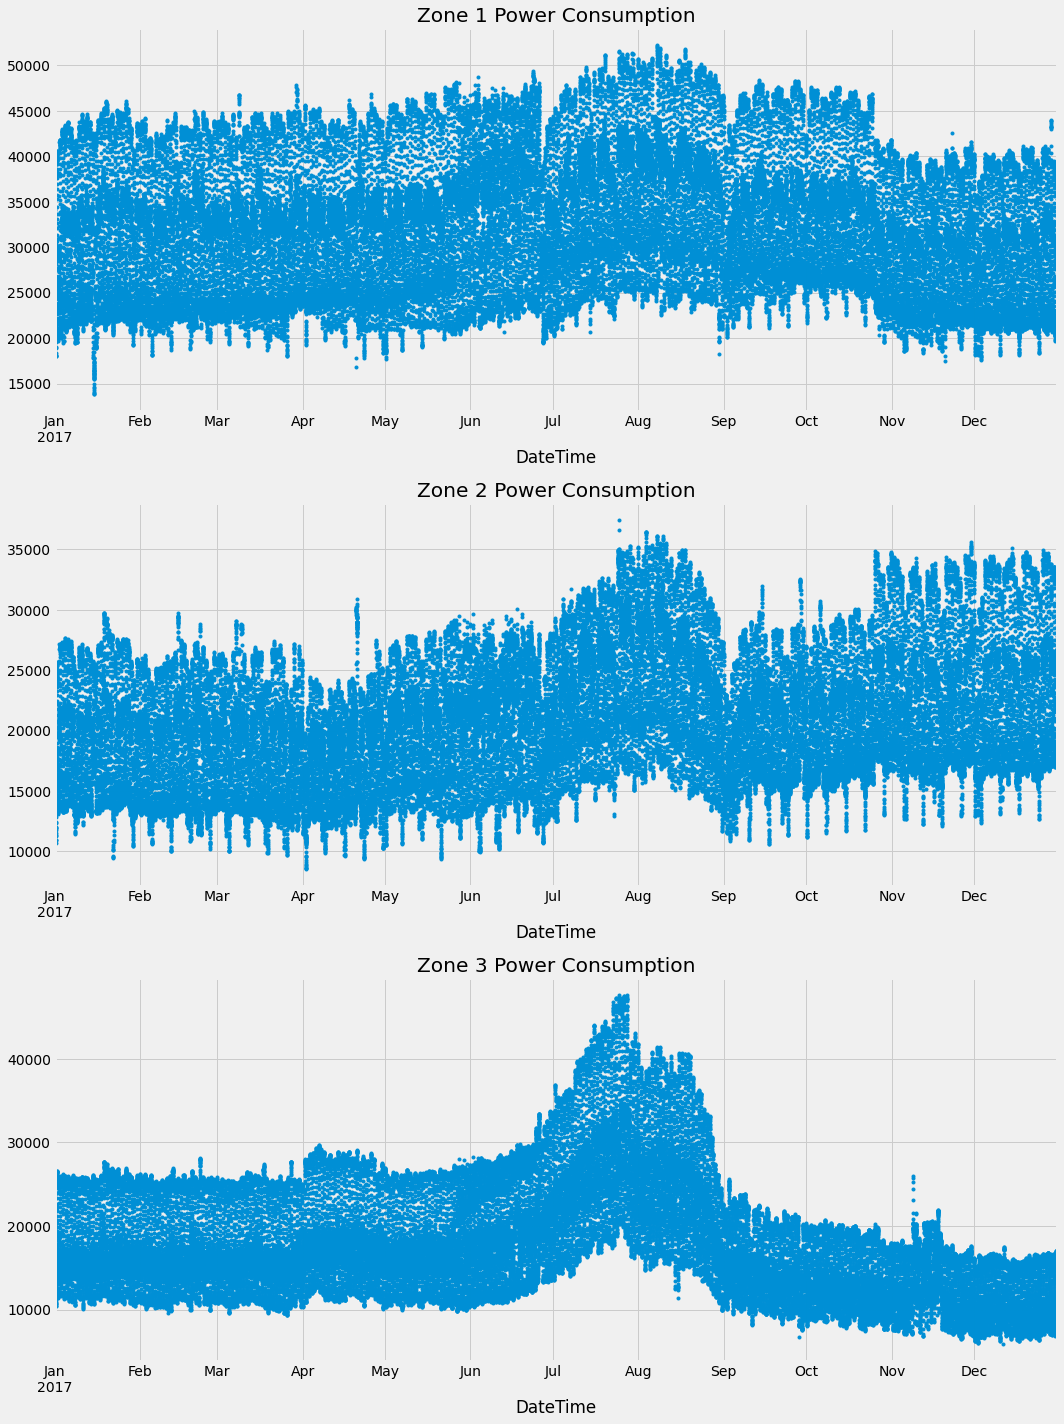

In [217]:
plt.subplot(3, 1, 1)
df['Zone 1 Power Consumption'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Zone 1 Power Consumption')

plt.subplot(3, 1, 2)
df['Zone 2  Power Consumption'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Zone 2 Power Consumption')

plt.subplot(3, 1, 3)
df['Zone 3  Power Consumption'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Zone 3 Power Consumption')
plt.tight_layout()
plt.show()

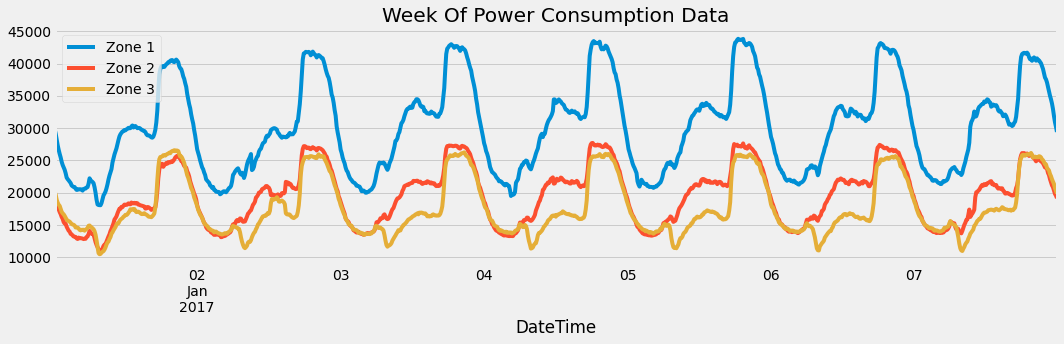

In [218]:
fig, ax = plt.subplots(figsize=(15, 5))
df['Zone 1 Power Consumption'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot(ax=ax, title='Week Of Power Consumption Data', label='Zone 1')
df['Zone 2  Power Consumption'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot(ax=ax, label='Zone 2' )
df['Zone 3  Power Consumption'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot(ax=ax, label='Zone 3')
ax.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.tight_layout()
plt.show()

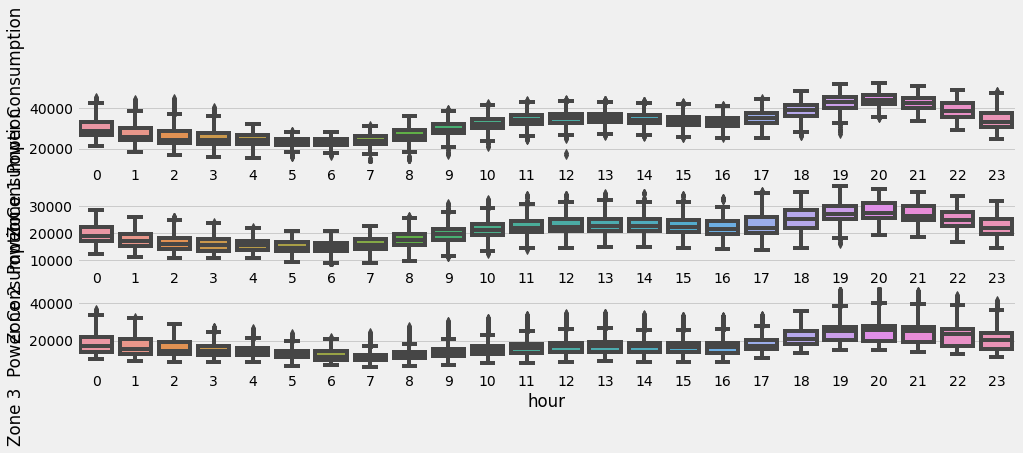

In [219]:
plt.subplot(3, 1, 1)
plt.rcParams['figure.figsize']=(15,15)
sns.boxplot(data=df, x='hour', y='Zone 1 Power Consumption', )
ax.set_title('Zone 1 Power Consumption by Hour')

plt.subplot(3, 1, 2)
plt.rcParams['figure.figsize']=(15,15)
sns.boxplot(data=df, x='hour', y='Zone 2  Power Consumption')
ax.set_title('Zone 2 Power Consumption by Hour')

plt.subplot(3, 1, 3)
plt.rcParams['figure.figsize']=(15,15)
sns.boxplot(data=df, x='hour', y='Zone 3  Power Consumption')
ax.set_title('Zone 3 Power Consumption by Hour')

plt.tight_layout()
plt.show()

# Other Feature Visualization

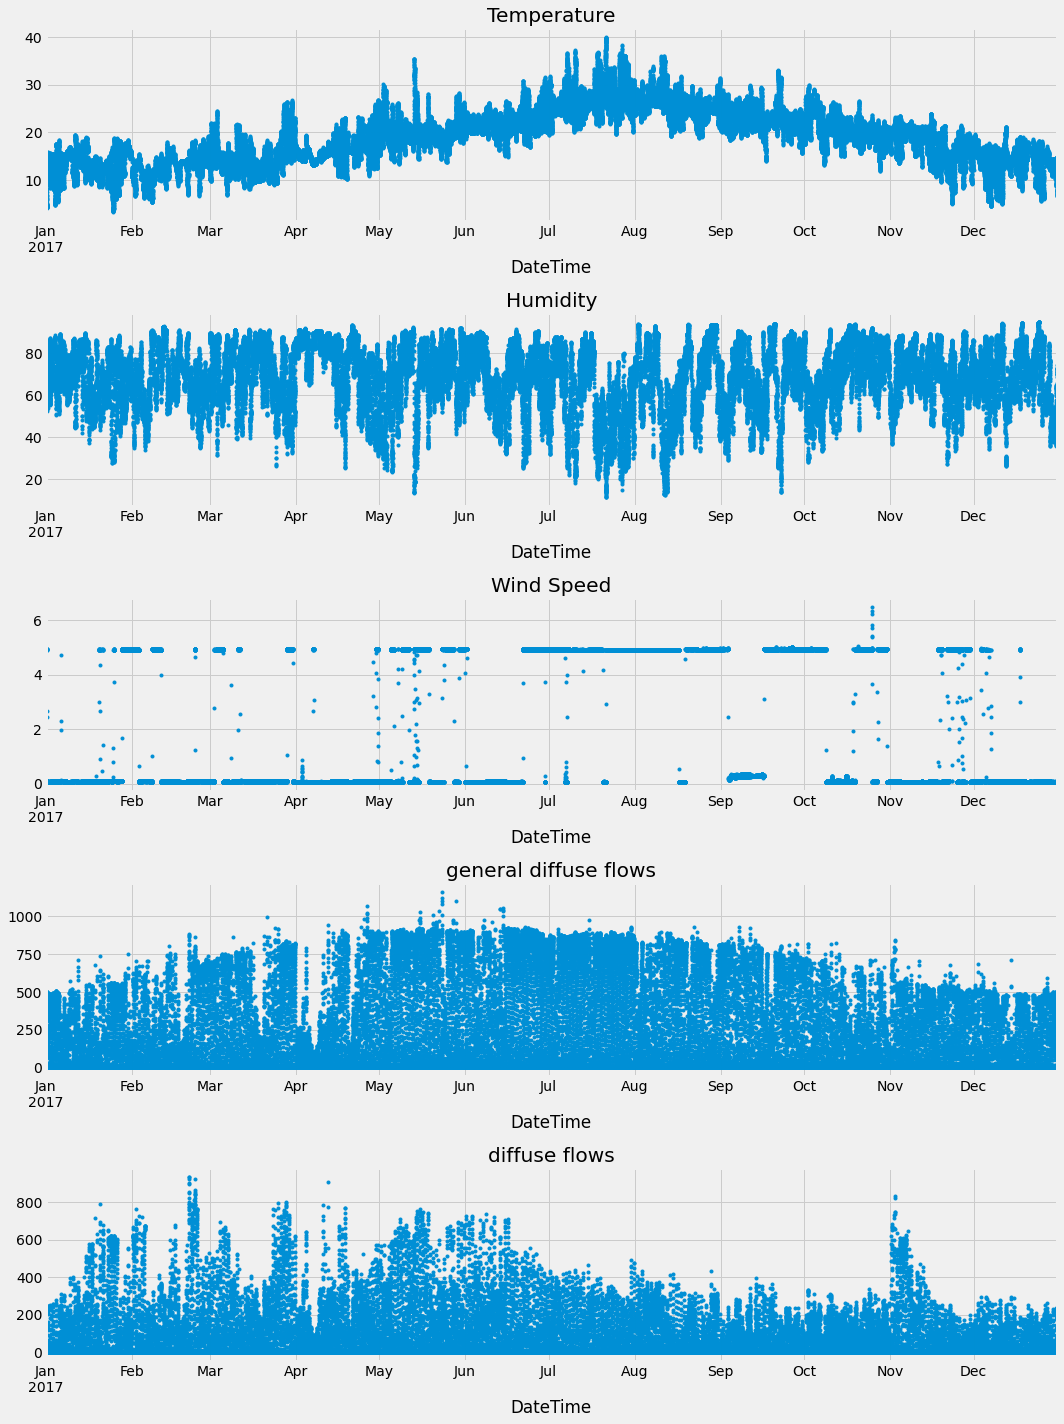

In [220]:
plt.subplot(5, 1, 1)
df['Temperature'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Temperature')

plt.subplot(5, 1, 2)
df['Humidity'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Humidity')

plt.subplot(5, 1, 3)
df['Wind Speed'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='Wind Speed')

plt.subplot(5, 1, 4)
df['general diffuse flows'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='general diffuse flows')

plt.subplot(5, 1, 5)
df['diffuse flows'].plot(style='.',
        figsize=(15, 20),
        color=color_pal[0],
        title='diffuse flows')
plt.tight_layout()
plt.show()

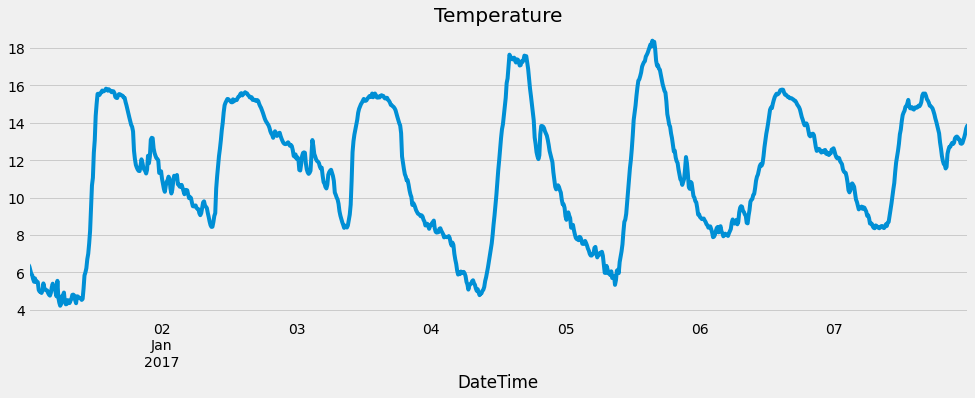

In [221]:
df['Temperature'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot( title='Temperature', figsize=(15, 5))
plt.show()

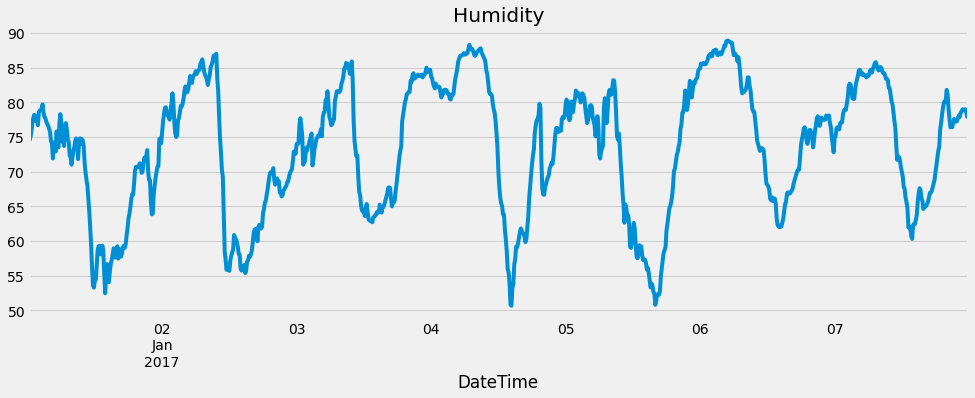

In [222]:
df['Humidity'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot( title='Humidity', figsize=(15, 5))
plt.show()

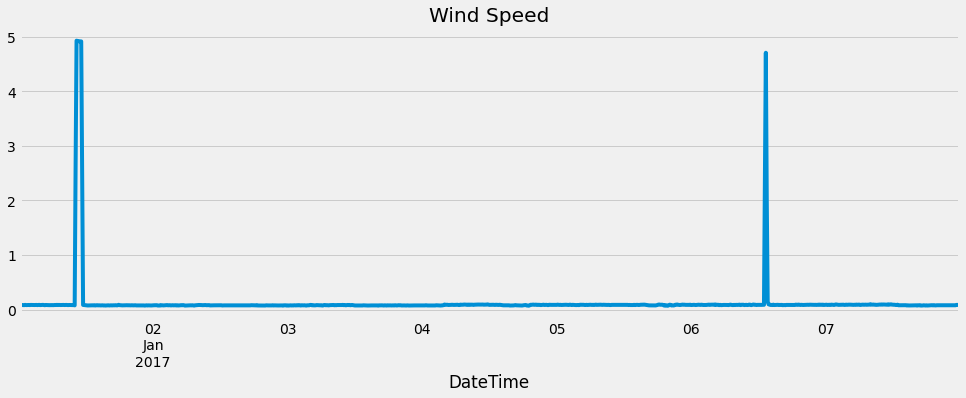

In [223]:
df['Wind Speed'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot( title='Wind Speed', figsize=(15, 5))
plt.show()

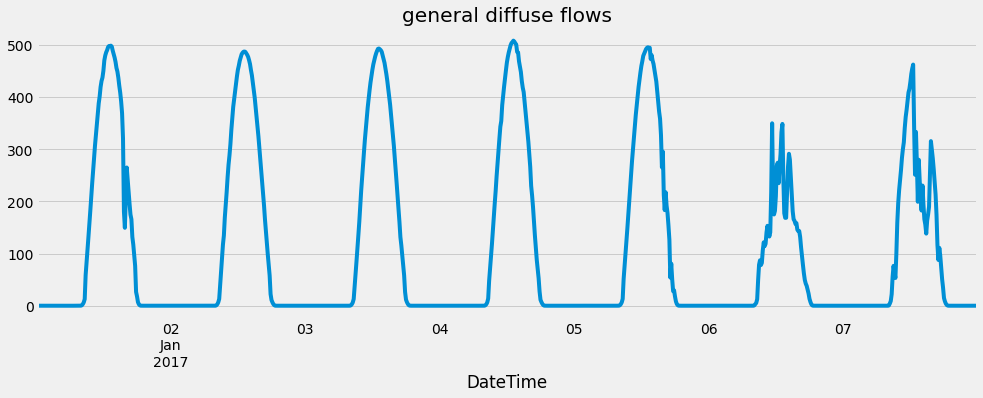

In [224]:
df['general diffuse flows'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot( title='general diffuse flows', figsize=(15, 5))
plt.show()

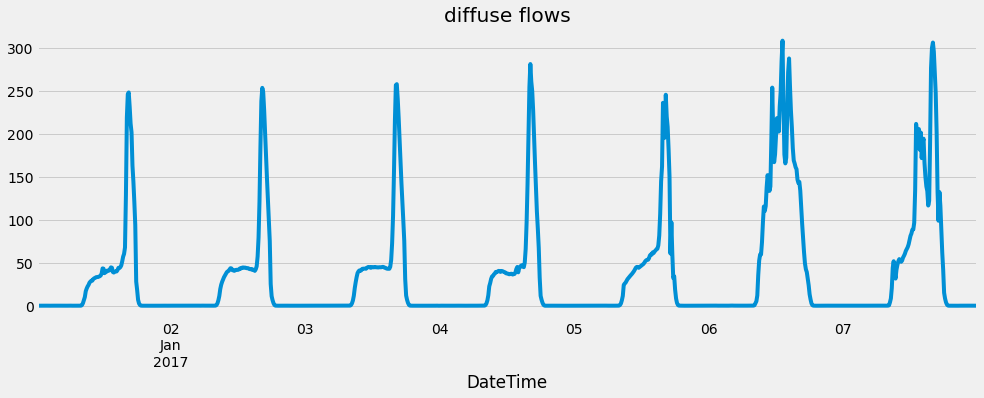

In [225]:
df['diffuse flows'].loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')] \
    .plot( title='diffuse flows', figsize=(15, 5))
plt.show()

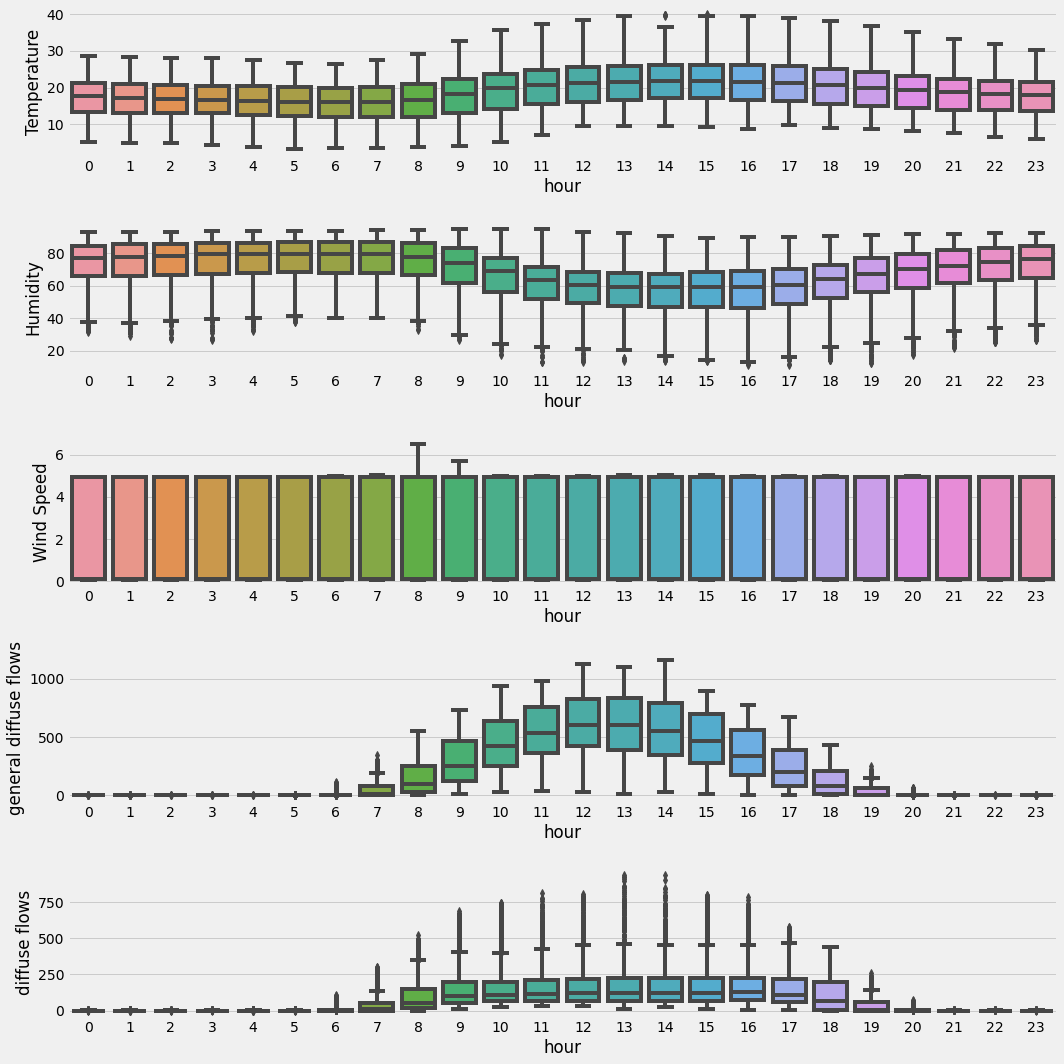

In [226]:
plt.subplot(5, 1, 1)
plt.rcParams['figure.figsize']=(15,20)
sns.boxplot(data=df, x='hour', y='Temperature', )
ax.set_title('Temperature')

plt.subplot(5, 1, 2)
plt.rcParams['figure.figsize']=(15,20)
sns.boxplot(data=df, x='hour', y='Humidity')
ax.set_title('Humidity')

plt.subplot(5, 1, 3)
plt.rcParams['figure.figsize']=(15,20)
sns.boxplot(data=df, x='hour', y='Wind Speed')
ax.set_title('Wind Speed')

plt.subplot(5, 1, 4)
plt.rcParams['figure.figsize']=(15,20)
sns.boxplot(data=df, x='hour', y='general diffuse flows')
ax.set_title('general diffuse flows')

plt.subplot(5, 1, 5)
plt.rcParams['figure.figsize']=(15,20)
sns.boxplot(data=df, x='hour', y='diffuse flows')
ax.set_title('diffuse flows')

plt.tight_layout()
plt.show()

# Outlier Analysis and Removal

(array([736439.50694444, 736439.51041667, 736439.51388889]),
 <a list of 3 Text major ticklabel objects>)

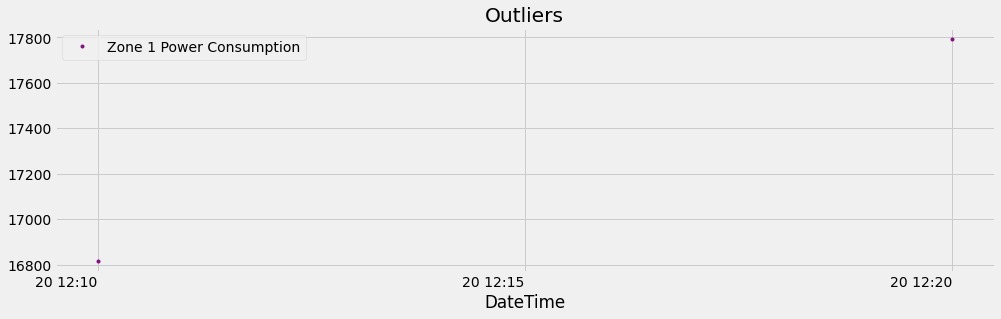

In [227]:
df[(df['Zone 1 Power Consumption'] < 24000) & (df['hour'] == 12)][['Zone 1 Power Consumption']].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')
plt.xticks(rotation=0)

In [228]:
df_outlier = df[(df['Zone 1 Power Consumption'] < 24000) & (df['hour'] == 12)][['Zone 1 Power Consumption']]
df_outlier

Zone 1 Power Consumption
DateTime                                     
2017-04-20 12:10:00               16814.98385
2017-04-20 12:20:00               17794.61787

In [229]:
df.drop(pd.Timestamp('2017-04-20 12:10:00'), inplace = True)
df.drop(pd.Timestamp('2017-04-20 12:20:00'), inplace = True)

# Feature Correlation Analysis

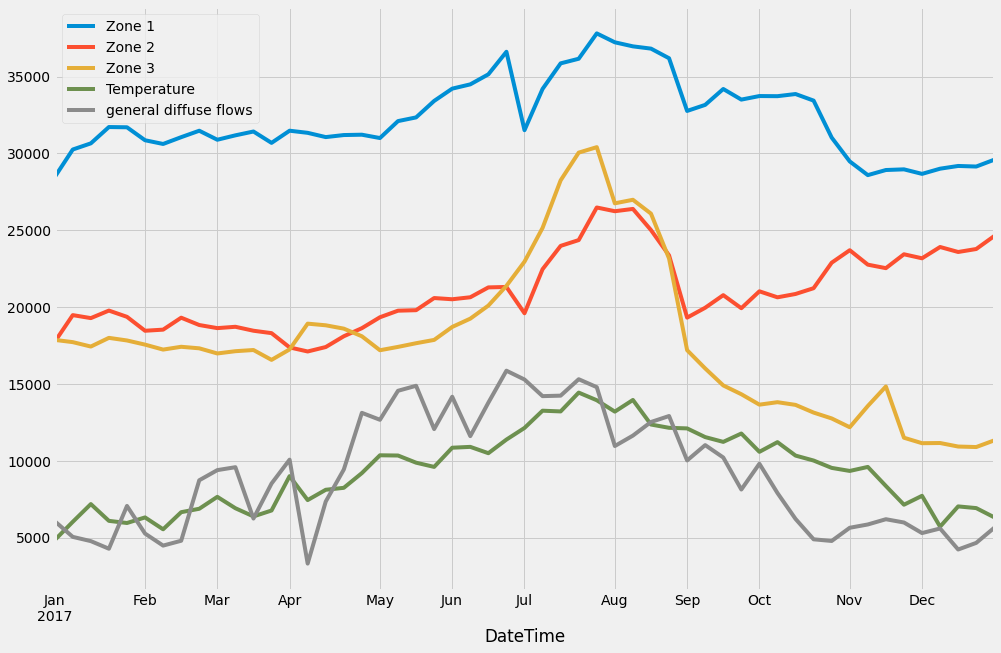

In [230]:
df['Zone 1 Power Consumption'].resample('W').mean().plot(legend=True, label='Zone 1',figsize=(15, 10))
df['Zone 2  Power Consumption'].resample('W').mean().plot(legend=True, label='Zone 2',figsize=(15, 10))
df['Zone 3  Power Consumption'].resample('W').mean().plot(legend=True, label='Zone 3',figsize=(15, 10))
(df['Temperature']*500).resample('W').mean().plot(legend=True, label='Temperature',figsize=(15, 10))
(df['general diffuse flows']*50).resample('W').mean().plot(legend=True, label='general diffuse flows',figsize=(15, 10))

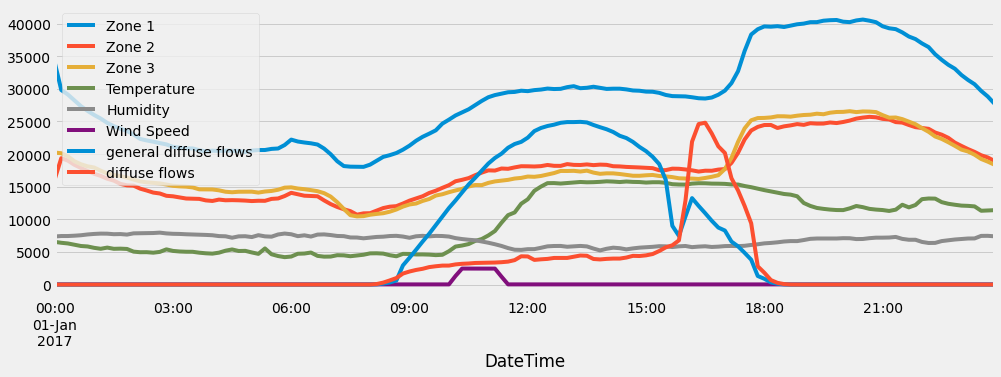

In [231]:
df['Zone 1 Power Consumption'].loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 1')
df['Zone 2  Power Consumption'].loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 2')
df['Zone 3  Power Consumption'].loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 3')
(df['Temperature']*1000).loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Temperature')
(df['Humidity']*100).loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Humidity')
(df['Wind Speed']*500).loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Wind Speed')
(df['general diffuse flows']*50).loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='general diffuse flows')
(df['diffuse flows']*100).loc[ (df.index < '2017-01-02 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='diffuse flows')

plt.show()

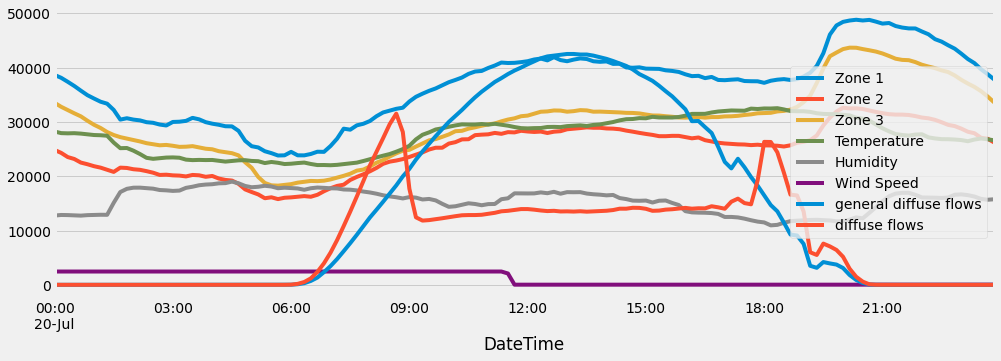

In [232]:
df['Zone 1 Power Consumption'].loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 1')
df['Zone 2  Power Consumption'].loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 2')
df['Zone 3  Power Consumption'].loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Zone 3')
(df['Temperature']*1000).loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Temperature')
(df['Humidity']*300).loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Humidity')
(df['Wind Speed']*500).loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='Wind Speed')
(df['general diffuse flows']*50).loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='general diffuse flows')
(df['diffuse flows']*100).loc[ (df.index >= '2017-07-20 00:00:00') & (df.index < '2017-07-21 00:00:00')] \
    .plot(  figsize=(15, 5), legend=True, label='diffuse flows')

plt.show()

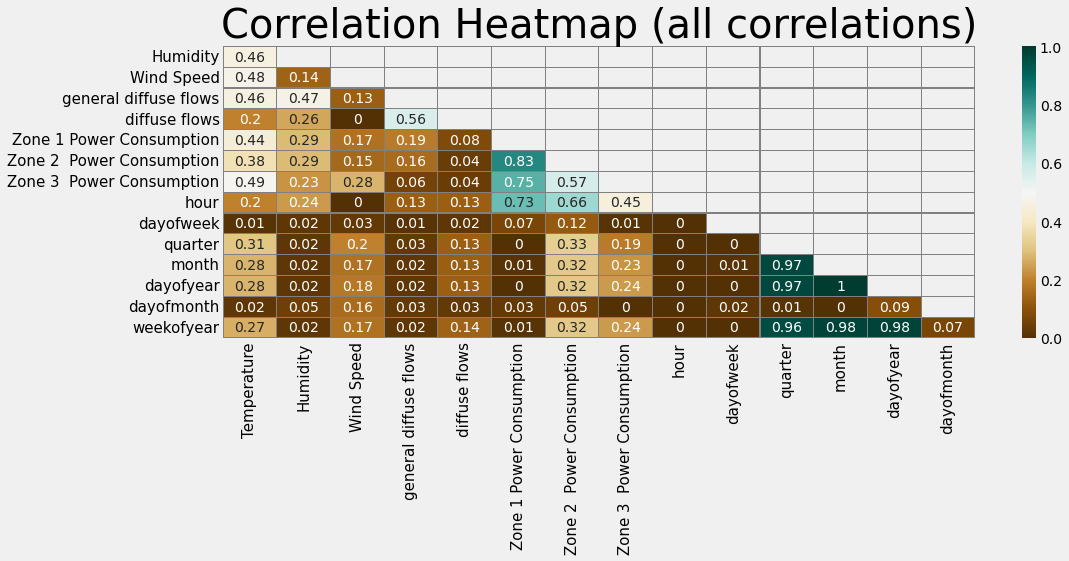

In [233]:
# To find the correlation among the columns using pearson method 

corr_matrix = df.corr().round(2).abs() 

# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = -1 # to show all correlations

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
plt.rcParams['figure.figsize']=(15,5)
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray', cmap="BrBG")
# increase the size of the labels.
s.set_title('Correlation Heatmap (all correlations)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)

plt.show()

In [234]:
df1c = df.resample('D').mean().dropna()

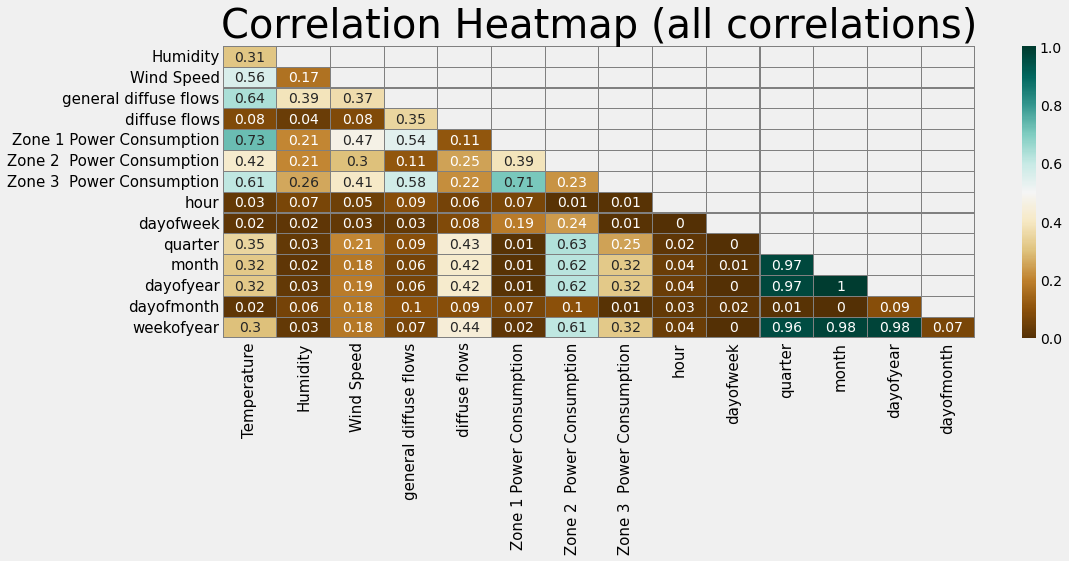

In [235]:
# To find the correlation among the columns using pearson method 

corr_matrix = df1c.corr().round(2).abs() 

# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = -1 # to show all correlations

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
plt.rcParams['figure.figsize']=(15,5)
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray', cmap="BrBG")
# increase the size of the labels.
s.set_title('Correlation Heatmap (all correlations)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)

plt.show()

Zone 1 power consumption is strongly correlated with temperature but this is showing only after the sampling of data is taken to as daily. 10 minute sampling does not shows strong correlation between zone 1 power consumption with temperature.

Zone 2 and zone 3 is not so much corelated to temperature even after sampling rate changed

# Select Features and Normalize

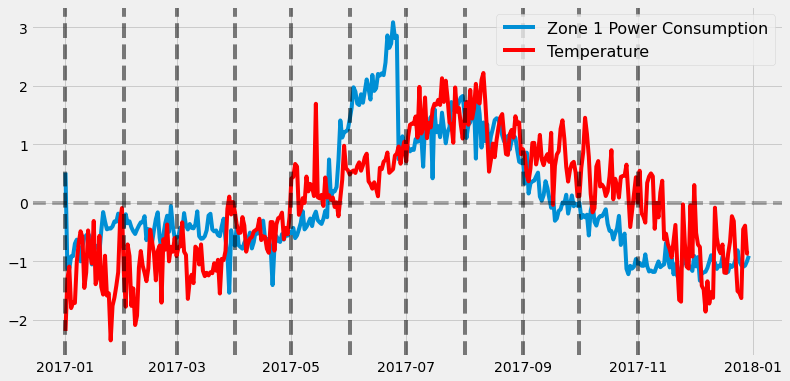

In [236]:
# Zone 1
df1 = df.filter(['Zone 1 Power Consumption', 'Temperature'], axis=1)
df1 = df1.asfreq(pd.infer_freq(df1.index))

avgs = df1.mean()
devs = df1.std()

for col in df1.columns:
    df1[col] = (df1[col] - avgs.loc[col]) / devs.loc[col]

plt.figure(figsize=(12,6))
Z1, = plt.plot(df1['Zone 1 Power Consumption'])
T1, = plt.plot(df1['Temperature'], color='red')

for month in range(1,12):
    plt.axvline(datetime(2017,month,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Zone 1 Power Consumption', 'Temperature'], fontsize=16)

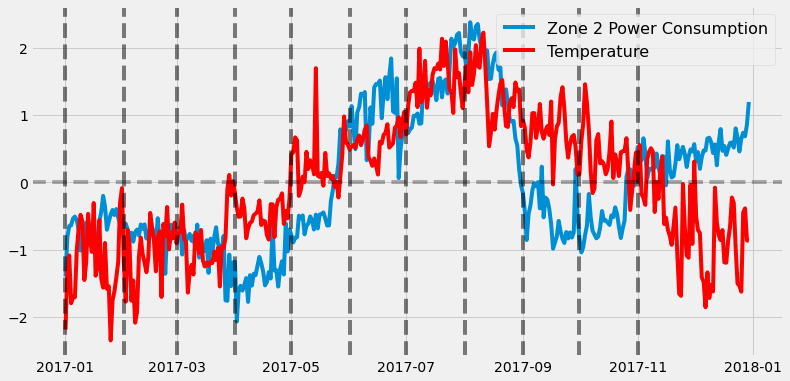

In [237]:
# Zone 2
df1 = df.filter(['Zone 2  Power Consumption', 'Temperature'], axis=1)
df1 = df1.asfreq(pd.infer_freq(df1.index))

avgs = df1.mean()
devs = df1.std()

for col in df1.columns:
    df1[col] = (df1[col] - avgs.loc[col]) / devs.loc[col]

plt.figure(figsize=(12,6))
Z1, = plt.plot(df1['Zone 2  Power Consumption'])
T1, = plt.plot(df1['Temperature'], color='red')

for month in range(1,12):
    plt.axvline(datetime(2017,month,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Zone 2 Power Consumption', 'Temperature'], fontsize=16)

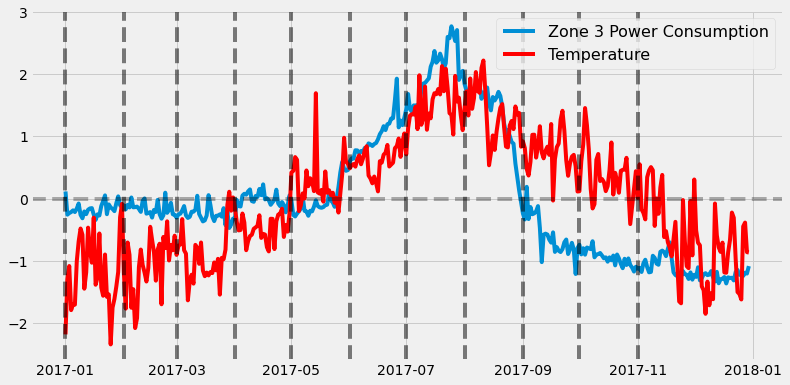

In [238]:
# Zone 3
df1 = df.filter(['Zone 3  Power Consumption', 'Temperature'], axis=1)
df1 = df1.asfreq(pd.infer_freq(df1.index))

avgs = df1.mean()
devs = df1.std()

for col in df1.columns:
    df1[col] = (df1[col] - avgs.loc[col]) / devs.loc[col]

plt.figure(figsize=(12,6))
Z1, = plt.plot(df1['Zone 3  Power Consumption'])
T1, = plt.plot(df1['Temperature'], color='red')

for month in range(1,12):
    plt.axvline(datetime(2017,month,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Zone 3 Power Consumption', 'Temperature'], fontsize=16)

# Univariate TIME Series Forecasting using SARIMA

## Original data stationarity

In [239]:
df1h = df.filter(['Zone 1 Power Consumption'], axis=1)
df1h = df1h.resample('60min').mean().dropna()
df1h = df1h.loc[(df1h.index > '12-01-2017') & (df1h.index < '2017-12-30 23:00:00')]
df1h.head(30)

Zone 1 Power Consumption
DateTime                                     
2017-12-01 01:00:00              23506.210395
2017-12-01 02:00:00              22137.389100
2017-12-01 03:00:00              21652.724968
2017-12-01 04:00:00              21495.564003
2017-12-01 05:00:00              21619.264893
2017-12-01 06:00:00              21056.527248
2017-12-01 07:00:00              18551.077313
2017-12-01 08:00:00              20355.893537
2017-12-01 09:00:00              23467.680608
2017-12-01 10:00:00              26351.330800
2017-12-01 11:00:00              28153.105198
2017-12-01 12:00:00              28094.296578
2017-12-01 13:00:00              28679.340938
2017-12-01 14:00:00              27616.730038
2017-12-01 15:00:00              26732.572878
2017-12-01 16:00:00              26866.413182
2017-12-01 17:00:00              32972.370088
2017-12-01 18:00:00              35566.032953
2017-12-01 19:00:00              35371.356148
2017-12-01 20:00:00              35434.220532
2017-12-01 21:00:00              34419.264892
2017-12-01 22:00:00              32346.768062
2017-12-01 23:00:00              29259.315590
2017-12-02 00:00:00              25344.486692
2017-12-02 01:00:00              22990.114067
2017-12-02 02:00:00              21607.097593
2017-12-02 03:00:00              21222.813688
2017-12-02 04:00:00              20852.724968
2017-12-02 05:00:00              21358.681877
2017-12-02 06:00:00              20678.326997

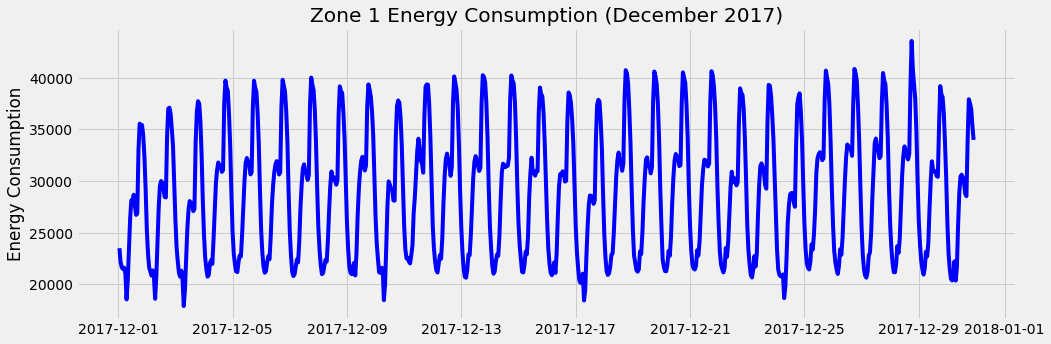

In [240]:
plt.figure(figsize=(15,5))
plt.ylabel('Energy Consumption')
plt.title('Zone 1 Energy Consumption (December 2017)')
plt.plot(df1h,'b-');

In [241]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Zone 1 Power Consumption Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -3.5929
p-value                          0.0059
Lags Used                       20.0000
Number of Observations Used    697.0000
Critical Value (1%)             -3.4398
Critical Value (5%)             -2.8657
Critical Value (10%)            -2.5690
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


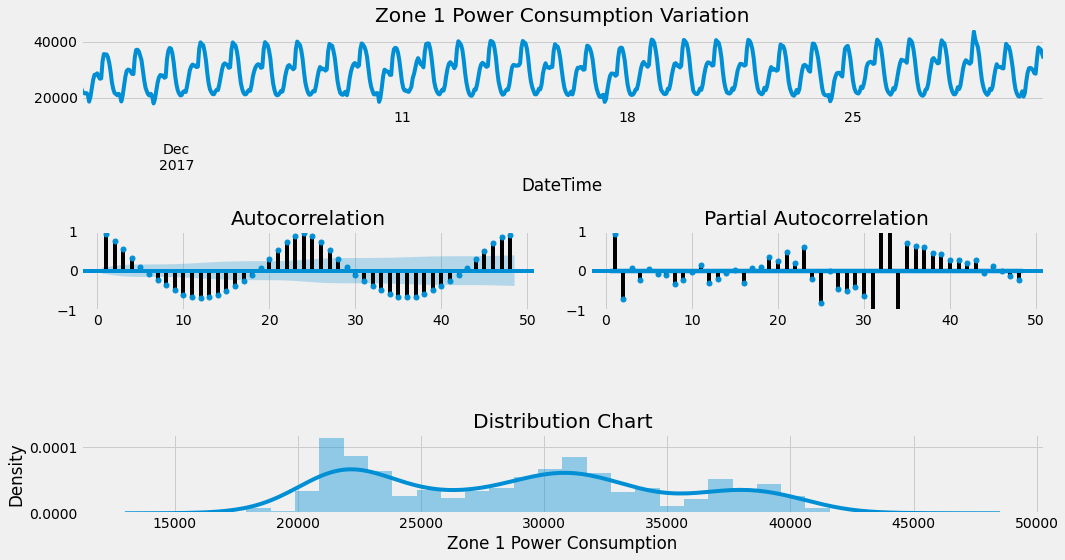

In [242]:
check_stationarity(df1h['Zone 1 Power Consumption'])

Results of Dickey-Fuller Test:
Test Statistic                  -6.1867
p-value                          0.0000
Lags Used                        7.0000
Number of Observations Used    686.0000
Critical Value (1%)             -3.4399
Critical Value (5%)             -2.8658
Critical Value (10%)            -2.5690
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


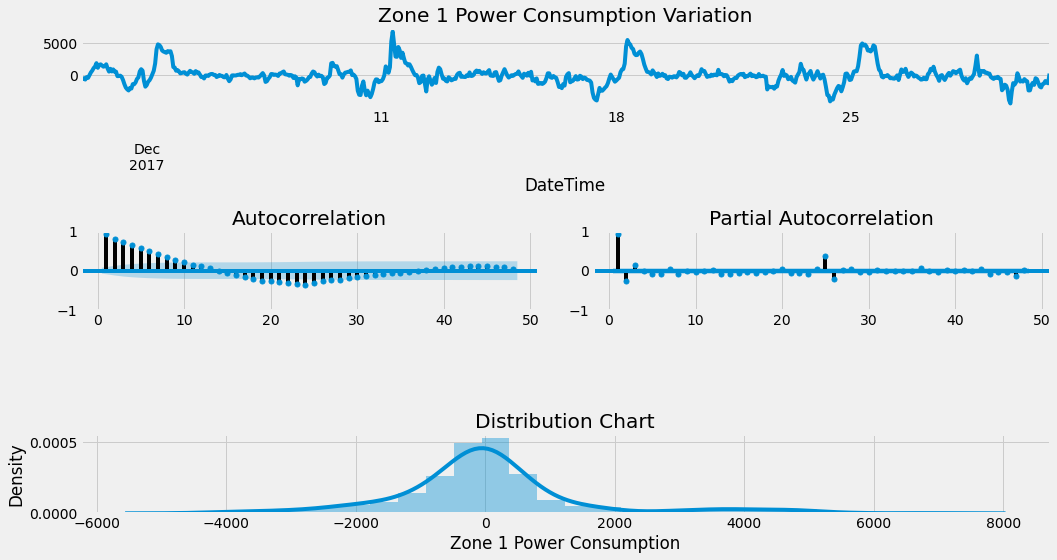

In [243]:
check_stationarity(df1h['Zone 1 Power Consumption'].diff(24).dropna())

## SARIMA Parameter Selection

In [244]:
# The following code is not run because it causes the runtime crash, it is running midway but we pick the best parameter on the list which is SARIMA(0,1,1)(0,1,1,24)
##model = pm.auto_arima(df.value, start_p=1, start_q=1,
#                      test='adf',       # use adftest to find optimal 'd'
#                      max_p=3, max_q=3, # maximum p and q
#                      m=1,              # frequency of series
#                      d=None,           # let model determine 'd'
#                      seasonal=TRUE,   # No Seasonality
#                      start_P=0, start_Q=0 
#                      D=0, 
#                      trace=True,
#                      error_action='ignore',  
#                      suppress_warnings=True, 
#                      stepwise=True)

#print(model.summary())

## Train test split

In [245]:
train = df1h.loc[df1h.index < '12-23-2017']
test = df1h.loc[df1h.index >= '12-23-2017']


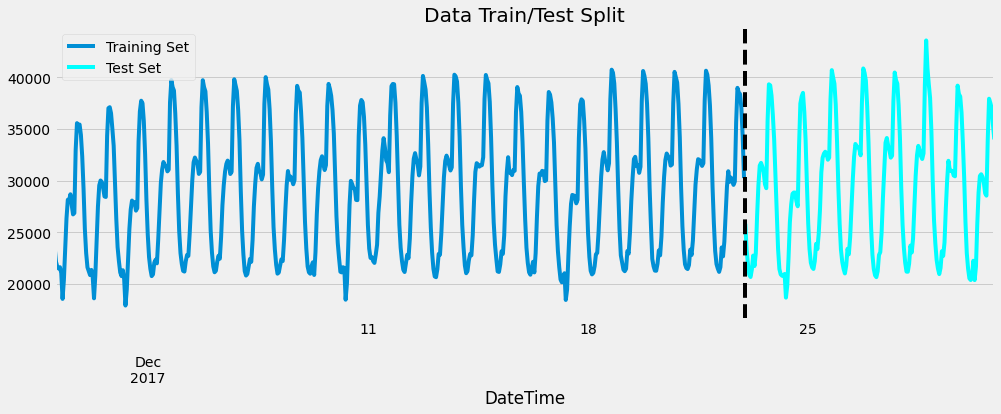

In [246]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set', color = 'cyan')
ax.axvline('12-23-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Sarima Model Training

In [247]:
final_model = SARIMAX(train,order=(0,1,1),seasonal_order=(0,1,1,24))
result = final_model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:           Zone 1 Power Consumption   No. Observations:                  527
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -3827.722
Date:                            Sat, 05 Nov 2022   AIC                           7661.443
Time:                                    08:41:28   BIC                           7674.099
Sample:                                12-01-2017   HQIC                          7666.409
                                     - 12-22-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2335      0.029      7.942      0.000       0.176       0.291
ma.S.L24      -0.6607      0.024   

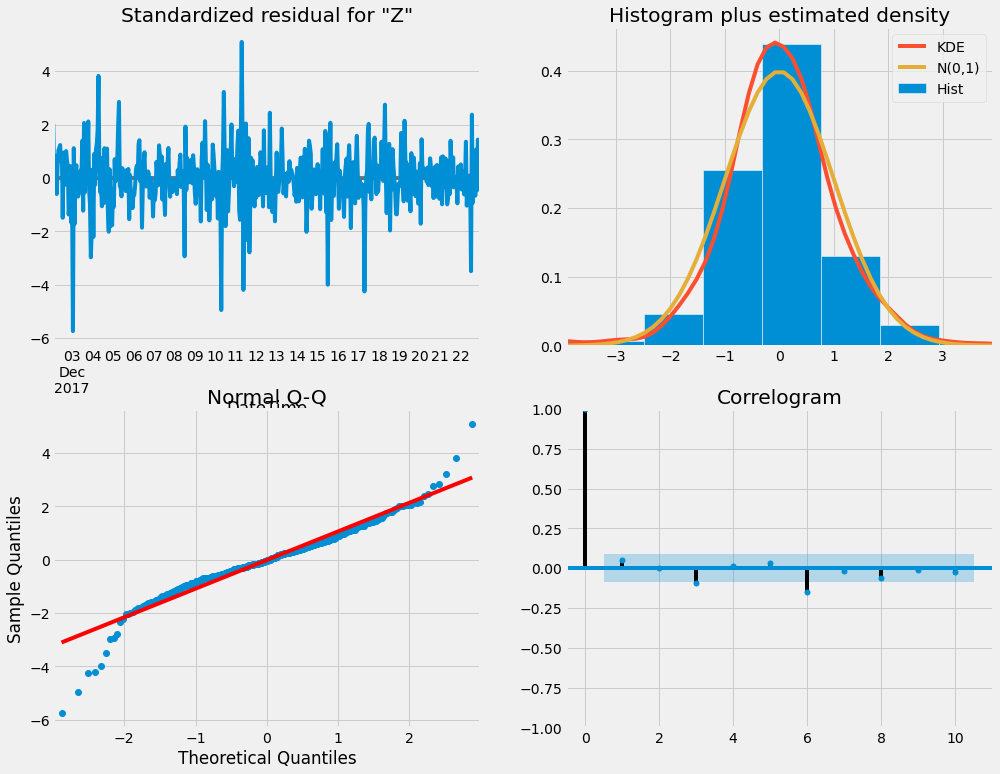

In [248]:
result.plot_diagnostics(figsize=(15, 12));

## Sarima model implementation for prediction testing

[Text(0, 0.5, 'Production'), Text(0.5, 0, 'Date')]

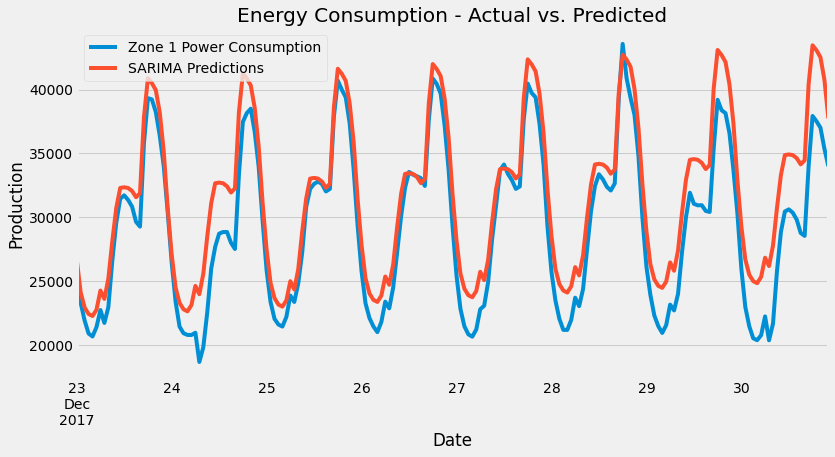

In [249]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
# Plot predictions against known values
title = 'Energy Consumption - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [250]:
def MAE(y,yhat):
    diff = np.abs(np.array(y)-np.array(yhat))
    try:
        mae =  round(np.mean(np.fabs(diff)),3)
    except:
        print("Error while calculating")
        mae = np.nan
    return mae

In [251]:
def fMAPE(y, yhat): 
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape =  round(np.mean(np.abs((y - yhat) / y)) * 100,2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape


In [252]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print("\n\n Accuracy measures ")
print('RMSE: %.3f' % rmse)

mae = MAE(test, predictions)
print('MAE: %d' % np.float(mae))

mape = fMAPE(test, predictions)
print('MAPE: %.3f' % np.float(mape))





 Accuracy measures 
RMSE: 2833.652
MAE: 7378
MAPE: 27.420


## SARIMA model implementation for forecasting

In [253]:
final_model = SARIMAX(df1h,order=(0,1,1),seasonal_order=(0,1,1,24))
result = final_model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:           Zone 1 Power Consumption   No. Observations:                  718
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -5290.411
Date:                            Sat, 05 Nov 2022   AIC                          10586.823
Time:                                    08:41:36   BIC                          10600.446
Sample:                                12-01-2017   HQIC                         10592.091
                                     - 12-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2473      0.025      9.770      0.000       0.198       0.297
ma.S.L24      -0.7414      0.023   

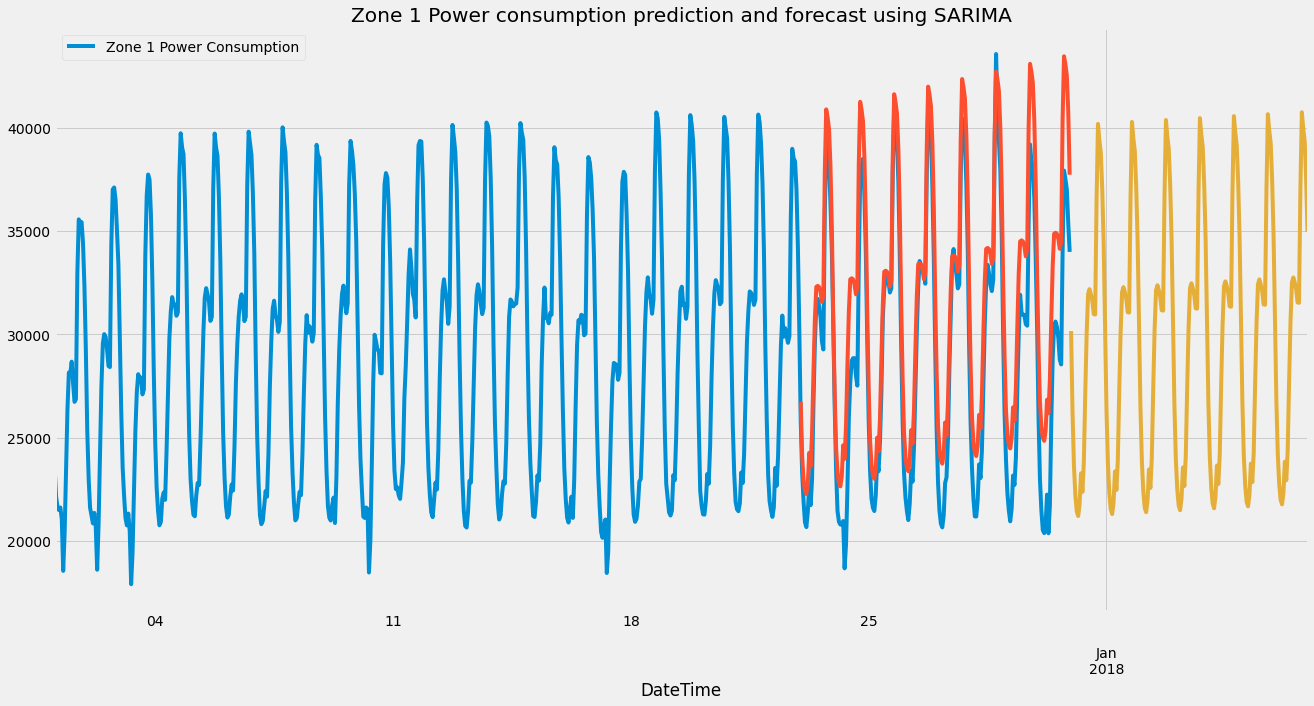

In [310]:
forecast = result.forecast(steps=24*7)
# Plot predictions against known values
fig, ax = plt.subplots(figsize=(20, 10))
df1h.plot(ax=ax, label='Training Set', title='Zone 1 Power consumption prediction and forecast using SARIMA')
predictions.plot(ax=ax, label='Prediction')
forecast.plot(ax=ax, label='Forecast')
plt.show()

# Univariate Forecasting using LSTM RNN

## Train Test Split

In [255]:
prediction_windows=24*7

In [256]:
train=df1h.iloc[:len(df1h)-prediction_windows]
test=df1h.iloc[len(df1h)-prediction_windows:]

## Scaling and data preparation for supervised learning

In [257]:
scaler=MinMaxScaler()

In [258]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [259]:
n_input=24 #Use 24 hours data to predict 23 th hour data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 


In [260]:
X_train=[]
y_train=[]
for i in range(n_input,len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [261]:
print(f'Given the Array: \n {X_train[0].flatten()}')
print(f'Predict this value: \n {y_train[0]}')

Given the Array: 
 [0.24515986 0.18521314 0.16398757 0.1571048  0.1625222  0.13787744
 0.02815275 0.10719361 0.24347247 0.36976021 0.44866785 0.44609236
 0.47171403 0.42517762 0.38645648 0.39231794 0.65972469 0.77331261
 0.76478686 0.76753996 0.72309059 0.63232682 0.49711368 0.32566607]
Predict this value: 
 [0.22255773]


## Define LSTM RNN model parameters/architectures

In [262]:
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, input_shape=(n_input, n_features), return_sequences=False))
#model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [263]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 24, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [264]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
17/17 [==============================] - 5s 36ms/step - loss: 0.1302
Epoch 2/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0749
Epoch 3/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0558
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0244
Epoch 5/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0151
Epoch 6/100
17/17 [==============================] - 2s 127ms/step - loss: 0.0119
Epoch 7/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0092
Epoch 8/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0077
Epoch 9/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0077
Epoch 10/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0084
Epoch 11/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0076
Epoch 12/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0071
Epoch 13/100
17/17 [====

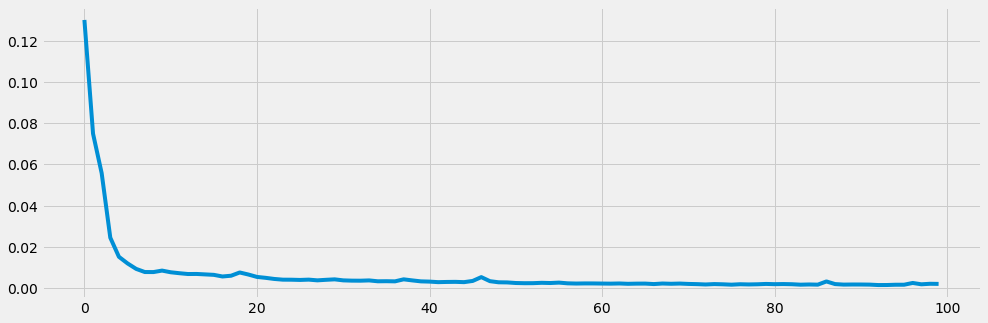

In [265]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Predict using trained LSTM model

In [266]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(test)):
    #get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 21ms/step


In [267]:
true_predictions = scaler.inverse_transform(test_predictions)

In [268]:
test['Predictions'] = true_predictions

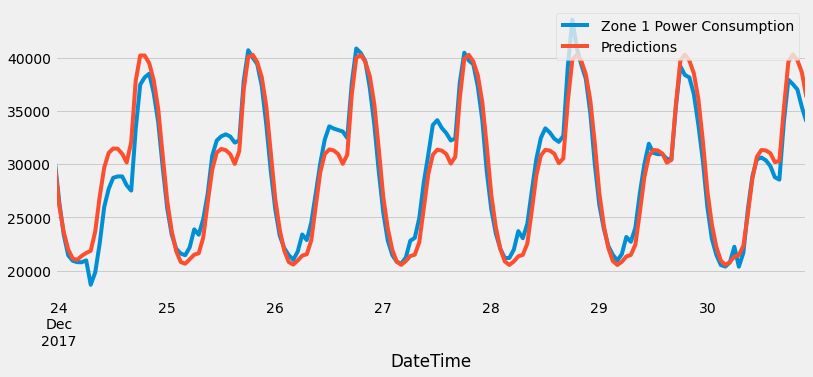

In [269]:
test.plot(figsize=(12,5))

In [270]:
pred_dates=np.asarray(test.index)
dates=np.asarray(df1h.index)

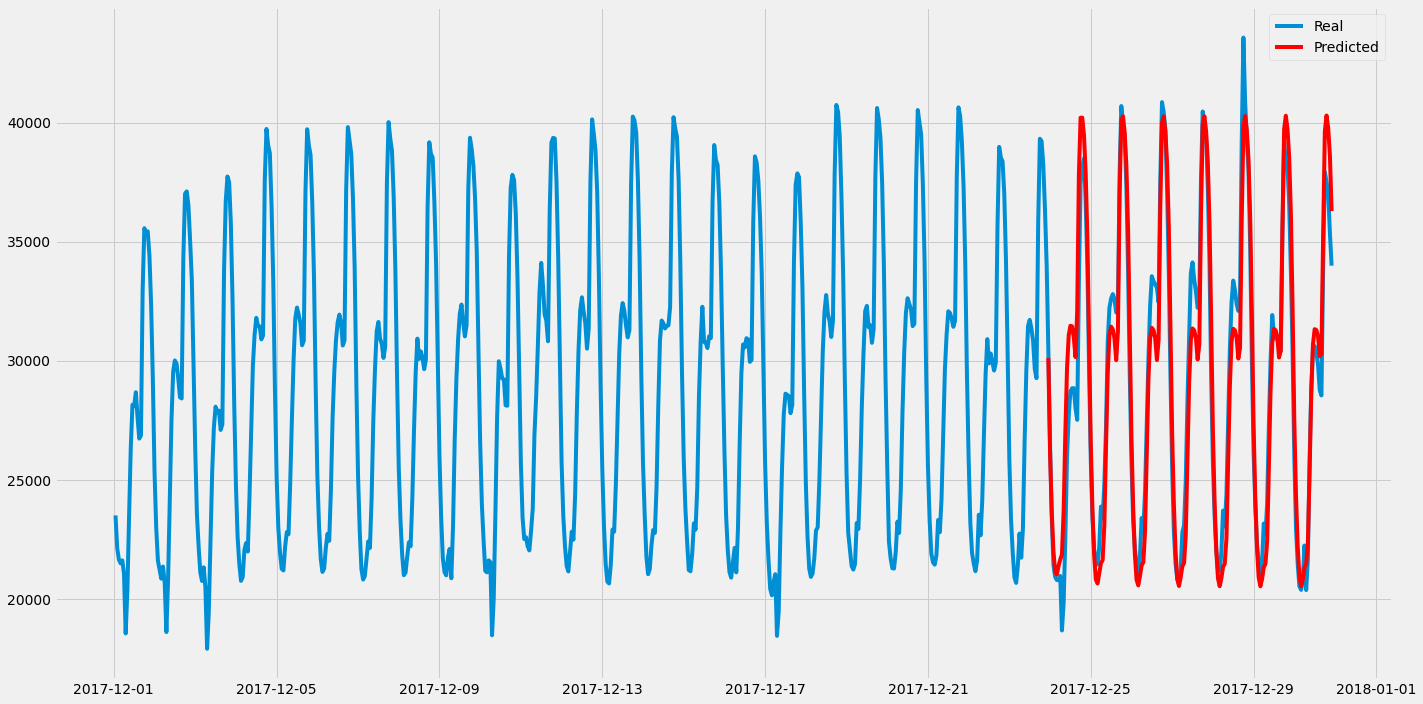

In [303]:
plt.figure(figsize=(20,10))
plt.plot(dates,df1h.values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.legend()
plt.tight_layout()
plt.show()

In [272]:
test.head()

Zone 1 Power Consumption   Predictions
DateTime                                                   
2017-12-23 23:00:00              30400.000000  30113.346229
2017-12-24 00:00:00              26492.268697  26119.563009
2017-12-24 01:00:00              23386.565272  23644.794074
2017-12-24 02:00:00              21442.839037  21997.997235
2017-12-24 03:00:00              20925.728772  21134.902903

In [273]:
rmse = np.sqrt(mean_squared_error(test['Zone 1 Power Consumption'], test['Predictions']))
print("\n\n Accuracy measures ")
print('RMSE: %.3f' % rmse)

mae = MAE(test['Zone 1 Power Consumption'], test['Predictions'])
print('MAE: %d' % np.float(mae))

mape = fMAPE(test['Zone 1 Power Consumption'], test['Predictions'])
print('MAPE: %.3f' % np.float(mape))



 Accuracy measures 
RMSE: 1669.588
MAE: 1360
MAPE: 4.710


## Forecasting using LSTM RNN Model

In [274]:
date_offset=24*7
forecast_dates =  (df1h.index + pd.DateOffset(hours=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2017-12-30 23:00:00', '2017-12-31 00:00:00',
               '2017-12-31 01:00:00', '2017-12-31 02:00:00',
               '2017-12-31 03:00:00', '2017-12-31 04:00:00',
               '2017-12-31 05:00:00', '2017-12-31 06:00:00',
               '2017-12-31 07:00:00', '2017-12-31 08:00:00',
               ...
               '2018-01-06 13:00:00', '2018-01-06 14:00:00',
               '2018-01-06 15:00:00', '2018-01-06 16:00:00',
               '2018-01-06 17:00:00', '2018-01-06 18:00:00',
               '2018-01-06 19:00:00', '2018-01-06 20:00:00',
               '2018-01-06 21:00:00', '2018-01-06 22:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=168, freq=None)

In [275]:
forecast=[]

first_eval_batch = test_predictions[-n_input:] #use the past 24 values of the predicted values to forecast
current_batch=np.reshape(first_eval_batch,(1,n_input,n_features))

for i in range(date_offset):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 21ms/step


In [282]:
forec_vals = np.array(forecast).reshape(-1,1)

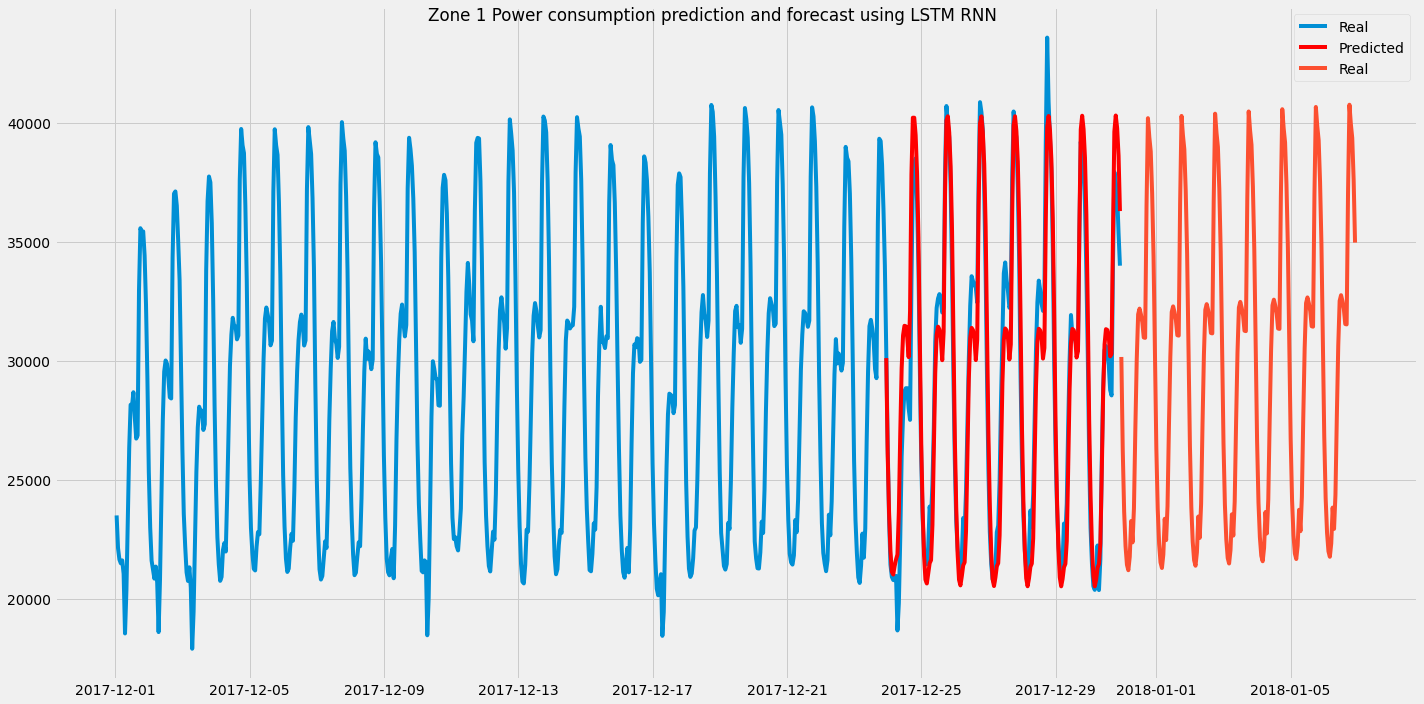

In [309]:
plt.figure(figsize=(20,10))
plt.plot(dates,df1h.values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,forec_vals, label='Real')
plt.legend()
plt.tight_layout()
plt.suptitle('Zone 1 Power consumption prediction and forecast using LSTM RNN')
plt.show()